## TODOs

* [ ] boundary layer not well resolved in openfoam. Can I extract data where the velocity profile tends to zero in the profile? Maybe I this is also related to the model parameters?
* [ ] h-finder does not work well in some cases (I think sharp gradients e.g. in the IC). E.g. the h-plot for the initial time steps is wrong 
* [ ] Project velocity profile to moments at inflow boundary -> compute errors?
    * maybe split in projection and model errors? First can clearly me mitiated by SMM, open question to answere here is if this also helps for the model errors.
        * Two main sources of model errors based on thesis: inflow + junctions
* [ ] write Elena
    * Get Diplomarbeit from Desire Plenker (ref in BA)
    * Deadlines?
    * Progress
    * Further proceeding/ work plan 
* [ ] SMM experiments
    * vary inflow BC position
    * vary between prescribring u, w, u and w
    * e.g. include dx_hb?


## Introduction and preliminary work

### Photographs of potential hydropower mines
![](./images/mine.png)
![](./images/mine_shaft.png)

### Schematic of exerimental setup of IWW
![](./images/experiment_3d_schematic.png)

![](./images/experiment_2d_schematic.png)

![](./images/experiment_measuring_points.png)

### Problem: 3d-2d mapping
![](./images/problem.png)

### Existing approach: analytical computation of vertical velocity 
![](./images/2d-schematic.png)

### Idea: Reduce mapping error using the Shallow Moment Hierarchy
![](./images/gmsh.png)

## The shallow moment method

## Prescription of a vertical velocity as boundary condition

![](./images/VerticalBC-1.jpg)

![](./images/VerticalBC-2.jpg)

![](./images/VerticalBC-3.jpg)

![](./images/VerticalBC-4.jpg)

### Remark

How about taking $\partial_x h_b$ as a boundary condition in order to describe a vertial acceleration? This would also work in the SWE setting. This would e.g. allow to prescribe $u$ completely and $W_0$. $W_k$ with $k > 0$ are not satisfied.

## Numerical test in a straight channel

In [1]:
#| code-fold: true
#| code-summary: "Packages and plotting settings"
#| output: false
import os
import numpy as np
import pyvista as pv
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from copy import deepcopy
from matplotlib.colors import Normalize
import matplotlib
from matplotlib.ticker import ScalarFormatter
# import scienceplots
# plt.style.use(['science','ieee'])
# plt.style.use(['science','~/.config/matplotlib/stylelib/ingo.mpl'])
# plt.style.use('~/.config/matplotlib/stylelib/ingo.mplstyle')
# matplotlib.use("pgf")
# matplotlib.rcParams.update({
#     "pgf.texsystem": "pdflatex",
#     'font.family': 'serif',
#     'text.usetex': True,
#     'pgf.rcfonts': False,
# })

# cm = plt.get_cmap('tab20')
# cm = plt.get_cmap('Dark2')
# for color in plt.cycler("color", cm.colors):
    # print(matplotlib.colors.to_hex(color['color']))

main_dir = os.getenv("SMS")
from code_11_ijshs import *

### Fully resolved (OpenFOAM) simulation

In [2]:
#| code-fold: true
#| code-summary: "Test: Load VTK"
#| output: false

filename = os.path.join(main_dir, "outputs/nozzle_openfoam/VTK/nozzle_openfoam_0/internal.vtu")
# filename = os.path.join(main_dir, "outputs/nozzle_openfoam/VTK/nozzle_mid_600/boundary/outflow.vtp")

mesh_test, scalar_field_names = read_vtk(filename)
print(f'Available cell field: {scalar_field_names}')

Available cell field: ['alpha.water', 'epsilon', 'k', 'nuTilda', 'nut', 'p_rgh', 'U']


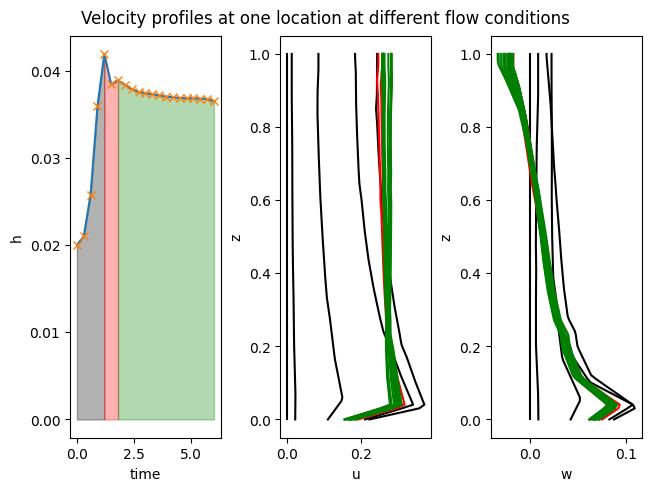

In [3]:
#| code-fold: true
#| code-summary: "Flow conditions at the beginning of the flow"
#| output: false

directory = os.path.join(main_dir, 'outputs/nozzle_openfoam/VTK')
pos, h, u, w, iteration = extract_1d_data(directory, pos=[0.3, 0, 0], stride=30)

fig, ax = plt.subplots(1, 3, constrained_layout=True)
fig.suptitle('Velocity profiles at one location at different flow conditions')
ax[0].set_xlabel('time')
ax[0].set_ylabel('h')
ax[1].set_xlabel('u')
ax[1].set_ylabel('z')
ax[2].set_xlabel('w')
ax[2].set_ylabel('z')

z = np.linspace(0, 1, 100)
dt = 0.01
time = dt * iteration

regions = [4,6]
ax[0].plot(time, h)
ax[0].plot(time, h, 'x')
ax[0].fill_between(time[:regions[0]+1], h[:regions[0]+1], color='k', alpha=0.3)
ax[0].fill_between(time[regions[0]:regions[1]+1], h[regions[0]:regions[1]+1], color='r', alpha=0.3)
ax[0].fill_between(time[regions[1]:], h[regions[1]:], color='g', alpha=0.3)
for i in range(u.shape[0]):
    if i <= regions[0]:
        ax[1].plot(u[i], z, 'k')
        ax[2].plot(w[i], z, 'k')
    elif i <= regions[1]:
        ax[1].plot(u[i], z, 'r')
        ax[2].plot(w[i], z, 'r')
    else:
        ax[1].plot(u[i], z, 'g')
        
        ax[2].plot(w[i], z, 'g')

[1, 1 - 2*x, 3*(2*x - 1)**2/2 - 1/2, 3*x - 5*(2*x - 1)**3/2 - 3/2, 35*(2*x - 1)**4/8 - 15*(2*x - 1)**2/4 + 3/8, -15*x/4 - 63*(2*x - 1)**5/8 + 35*(2*x - 1)**3/4 + 15/8, 231*(2*x - 1)**6/16 - 315*(2*x - 1)**4/16 + 105*(2*x - 1)**2/16 - 5/16, 35*x/8 - 429*(2*x - 1)**7/16 + 693*(2*x - 1)**5/16 - 315*(2*x - 1)**3/16 - 35/16, 6435*(2*x - 1)**8/128 - 3003*(2*x - 1)**6/32 + 3465*(2*x - 1)**4/64 - 315*(2*x - 1)**2/32 + 35/128]
Moments: [ 0.27685904 -0.00702969 -0.00853722 -0.0107907  -0.01194022 -0.01758198
 -0.01976391 -0.01828284 -0.01615363]
errors: [0.0001805692560933374, 0.0001636843161703276, 0.00014855520973367303, 0.00013114251982102346, 0.00011437423302610301, 8.493315111462066e-05, 5.353596869698015e-05, 3.040853788849574e-05, 1.4771595177493217e-05]
relative errors: [1.0, 1.1031555149452412, 1.2155026835952676, 1.3768932939504974, 1.5787581810679951, 2.126016210674346, 3.372858668447386, 5.938110433177091, 12.224086425578617]


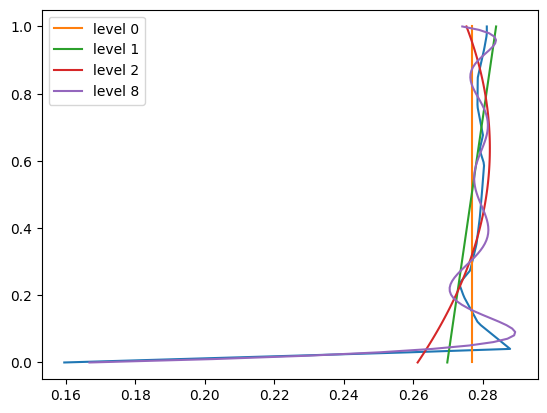

In [4]:
from library.model.model import *
level = 8
basis_analytical =Legendre_shifted(order=level+1)
basis_readable = [basis_analytical.get(k) for k in range(level+1)]
basis = [basis_analytical.get_lambda(k) for k in range(level+1)]
print(basis_readable)

u_test = u[-1]
moments = project_to_smm(u_test, z, basis=basis)
print(f'Moments: {moments}')
reconstructions = []
for k in range(level+1):
    recon = moments[0] * basis[0](z)
    for i in range(1,k+1):
        recon += moments[i] * basis[i](z)
    reconstructions.append(recon)

errors = []
rel_errors = []
error_0 = np.trapz((u_test - reconstructions[0])**2, z)
for k in range(level+1):
    error = np.trapz((u_test - reconstructions[k])**2, z)
    errors.append(error)
    rel_errors.append(error_0/error)


fig, ax = plt.subplots()
plt.plot(u_test, z)
# for k in range(level+1):
#     ax.plot(reconstructions[k], z, label=f'level {k}')

for k in [0, 1, 2, 8]:
    ax.plot(reconstructions[k], z, label=f'level {k}')

plt.legend()

print(f'errors: {errors}')
print(f'relative errors: {rel_errors}')

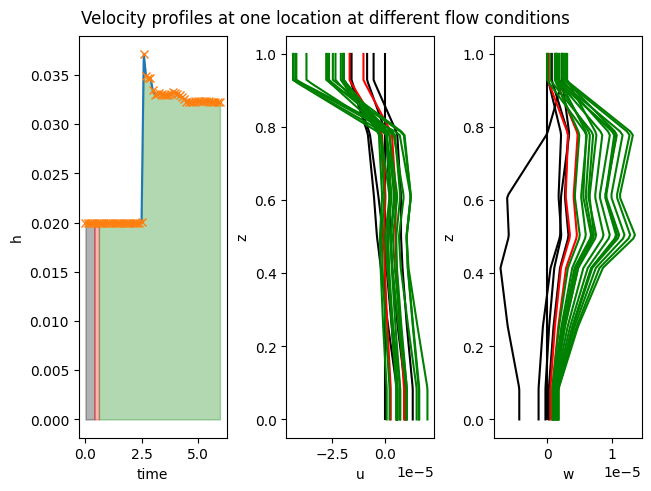

In [6]:
#| code-fold: true
#| code-summary: "Flow conditons at the end of the channel"
#| output: true

directory = os.path.join(main_dir, 'outputs/nozzle_openfoam/VTK')
pos_end, h_end, u_end, w_end, iteration_end = extract_1d_data(directory, pos=[1.5, 0, 0], stride=10)

fig, ax = plt.subplots(1, 3, constrained_layout=True)
fig.suptitle('Velocity profiles at one location at different flow conditions')
ax[0].set_xlabel('time')
ax[0].set_ylabel('h')
ax[1].set_xlabel('u')
ax[1].set_ylabel('z')
ax[2].set_xlabel('w')
ax[2].set_ylabel('z')

z = np.linspace(0, 1, 100)
dt = 0.01
time = dt * iteration_end

regions = [4,6]
ax[0].plot(time, h_end)
ax[0].plot(time, h_end, 'x')
ax[0].fill_between(time[:regions[0]+1], h_end[:regions[0]+1], color='k', alpha=0.3)
ax[0].fill_between(time[regions[0]:regions[1]+1], h_end[regions[0]:regions[1]+1], color='r', alpha=0.3)
ax[0].fill_between(time[regions[1]:], h_end[regions[1]:], color='g', alpha=0.3)
for i in range(u.shape[0]):
    if i <= regions[0]:
        ax[1].plot(u_end[i], z, 'k')
        ax[2].plot(w_end[i], z, 'k')
    elif i <= regions[1]:
        ax[1].plot(u_end[i], z, 'r')
        ax[2].plot(w_end[i], z, 'r')
    else:
        ax[1].plot(u_end[i], z, 'g')
        
        ax[2].plot(w_end[i], z, 'g')

In [ ]:
#| code-fold: true
#| code-summary: "Plot height field"
# | output: true
# mesh.plot(scalars=scalar_field_names[0])

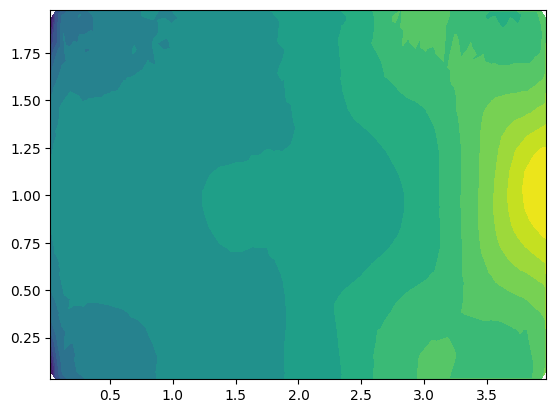

In [ ]:

#| code-fold: true
#| code-summary: "Contour map height field"
# | output: true
cell_centers = np.array(mesh.cell_centers().points)
field_0 = np.array(mesh.cell_data[scalar_field_names[0]])
plt.tricontourf(cell_centers[:,0], cell_centers[:,1], field_0, levels=20)

### Mapping from 3d to 2d

### Depth-averaged (Shallow Moment) simulation

In [ ]:
#| code-fold: true
#| code-summary: "Imports"
import numpy as np
import pytest
from types import SimpleNamespace

from library.model.model import *
from library.pysolver.solver import *
import library.model.initial_conditions as IC
import library.model.boundary_conditions as BC
from library.pysolver.ode import RK1
import library.misc.io as io
from library.pysolver.reconstruction import GradientMesh
import library.mesh.mesh as petscMesh
import library.postprocessing.postprocessing as postprocessing
import argparse


In [ ]:
#| code-fold: true
#| code-summary: "Mesh"
#| output: false
# mesh = petscMesh.Mesh.from_gmsh( os.path.join(main_dir, "meshes/quad_2d/mesh_coarse.msh"))
mesh = petscMesh.Mesh.from_gmsh( os.path.join(main_dir, "meshes/simple_openfoam/mesh_2d_mid.msh"))
# mesh = petscMesh.Mesh.from_gmsh( os.path.join(main_dir, "meshes/simple_openfoam/mesh_2d_finest.msh"))
# mesh = petscMesh.Mesh.from_gmsh( os.path.join(main_dir, "meshes/channel_2d_hole_sym/mesh_fine.msh"))
# mesh = petscMesh.Mesh.from_gmsh( os.path.join(main_dir, "meshes/channel_2d_hole_sym/mesh_finer.msh"))
# mesh = petscMesh.Mesh.from_gmsh( os.path.join(main_dir, "meshes/channel_2d_hole_sym/mesh_finest.msh"))

print(f'Available boundary condition names: {mesh.boundary_conditions_sorted_names}')


Available boundary condition names: ['inflow' 'top' 'outflow' 'bottom']


In [ ]:
#| code-fold: true
#| code-summary: "Generate boundary data"
#| output: false 


#TODO 


In [ ]:
#| code-fold: true
#| code-summary: "Model"
level = 1

# inflow_dict = {i: "0.0" for i in range(1, 2 * (1 + level) + 1)}
inflow_dict = {}
# inflow_dict[0] = "0.1*sympy.sin(2*3.14*time)+ 1.0 + 0.1*X[1]"
h0 = "Q[0]"
hu0 = 1.0
w0 = 0.0
dxh = f"(Q[0] - {h0})/(2*dX)"
# dxh = f"0"
dxhu = f"(Q[1] - {hu0})/(2*dX)"
nominator = f"-({w0} + Q[2] - 3/2 * dX * {dxhu} + 3/2 * dX * {hu0}/{h0} * {dxh})"
denominator = f"1/2 * dX / {h0} * {dxh} + 1"
inflow_dict[0] = f"{1.0}"
inflow_dict[1] = f"{hu0}"
inflow_dict[2] = f'{nominator}/{denominator}'
# inflow_dict[2] = f'{nominator}/{denominator}'
# outflow_dict = {0: f"1.0"}
# outflow_dict = {3: "0.0"}
# outflow_dict = {4: "0.0"}
outflow_dict = {}

#TODO
data_dict = {}


offset = level+1
bcs = BC.BoundaryConditions(
    [
        BC.FromData(physical_tag='left', prescribe_fields=data_dict, timeline=timeline),
        # BC.InflowOutflow(physical_tag="inflow", prescribe_fields=inflow_dict),
        BC.InflowOutflow(physical_tag="outflow", prescribe_fields= outflow_dict),
        BC.Wall(physical_tag="top", momentum_field_indices=[[1 + i*offset, 1+offset+i*offset] for i in range(level)], wall_slip=0.),
        BC.Wall(physical_tag="bottom", momentum_field_indices=[[1 + i*offset, 1+offset+i*offset] for i in range(level)], wall_slip=0.),
        # BC.Periodic(physical_tag="top", periodic_to_physical_tag='bottom'),
        # BC.Periodic(physical_tag="bottom", periodic_to_physical_tag='top'),
        # BC.Extrapolation(physical_tag="top"),
        # BC.Extrapolation(physical_tag="bottom"),
        # BC.Extrapolation(physical_tag="left"),
        # BC.Extrapolation(physical_tag="right"),
    ]
)


ic = IC.Constant(
    constants=lambda n_fields: np.array(
        [1.0, 0.0, 0.0] + [0.0 for i in range(n_fields - 3)]
    )
)

def custom_ic(x):
    Q = np.zeros(3+2*level, dtype=float)
    Q[0] = 2*np.ones_like(x[0])
    Q[1] = x[0]
    Q[2] = x[1]
    Q[3] = x[0]**2 
    Q[4] = x[1]**2 
    return Q

# ic = IC.UserFunction(custom_ic)

settings = Settings(
    name="ShallowMoments2d",
    parameters={"g": 9.81, "C": 30.0, "nu": 1.034*10**(-6)},
    reconstruction=recon.constant,
    num_flux=flux.LLF(),
    nc_flux=nonconservative_flux.segmentpath(1),
    compute_dt=timestepping.adaptive(CFL=.45),
    time_end=2.,
    output_snapshots=100,
    output_clean_dir=True,
    output_dir="outputs/output_jax2",
)


model = ShallowMoments2d(
    dimension=2,
    fields=3 + 2 * level,
    aux_fields=0,
    parameters=settings.parameters,
    boundary_conditions=bcs,
    initial_conditions=ic,
    # settings={"friction": []},
    settings={"friction": ["chezy", "newtonian"]},
    basis=Basis(basis=Legendre_shifted(order=level)),
)




In [ ]:
#| code-fold: true
#| code-summary: "Simulation"
#| output: false
jax_fvm_unsteady_semidiscrete(
    mesh, model, settings, ode_solver_flux=RK1, ode_solver_source=RK1
)
io.generate_vtk(os.path.join(settings.output_dir, f'{settings.name}.h5'))
# postprocessing.recover_3d_from_smm_as_vtk(
#     model,
#     settings.output_dir,
#     os.path.join(settings.output_dir, "mesh.hdf5"),
#     os.path.join(settings.output_dir, "fields.hdf5"),
#     Nz=10,
#     start_at_time=1.0,
# )

1 0.004710291839952075 0.004710291839952075---------------------------- 
2 0.00942058367990415 0.004710291839952075
3 0.014130875519856225 0.004710291839952075
4 0.0188411673598083 0.004710291839952075
5 0.023551459199760375 0.004710291839952075
6 0.02826175103971245 0.004710291839952075
7 0.03297204287966453 0.004710291839952075
8 0.0376823347196166 0.004710291839952075
9 0.04239262655956867 0.004710291839952075
10 0.04710291839952074 0.004710291839952075
11 0.051813210239472815 0.004710291839952075
12 0.05652350207942489 0.004710291839952075
13 0.06123379391937696 0.004710291839952075
14 0.06594408575932903 0.004710291839952075
15 0.0706543775992811 0.004710291839952075
16 0.07536466943923317 0.004710291839952075
17 0.08007496127918524 0.004710291839952075
18 0.08478525311913732 0.004710291839952075
19 0.08949554495908939 0.004710291839952075
20 0.09420583679904146 0.004710291839952075
21 0.09891612863899353 0.004710291839952075
22 0.1036264204789456 0.004710291839952075
23 0.1083367

In [ ]:
#| code-fold: true
#| code-summary: "Load 2d VTK"
#| output: true
filename = os.path.join(main_dir, os.path.join(settings.output_dir, "out.98.vtk"))
reader = pv.get_reader(filename)
mesh = reader.read()
scalar_field_names = mesh.cell_data.keys()
print(f'Available cell field: {scalar_field_names}')

Available cell field: ['0', '1', '2', '3', '4']


In [ ]:
#| code-fold: true
#| code-summary: "Plot height field"
# | output: true
mesh.plot(scalars=scalar_field_names[0])

Widget(value='<iframe src="http://localhost:41449/index.html?ui=P_0x7fd4f95daf10_0&reconnect=auto" class="pyvi…

Exception raised
KeyError('e5b247c2704fa3e2f55231d5eca299b4_69024f')
Traceback (most recent call last):
  File "/home/ingo/miniforge3/envs/sms/lib/python3.9/site-packages/wslink/protocol.py", line 308, in onCompleteMessage
    results = func(*args, **kwargs)
  File "/home/ingo/miniforge3/envs/sms/lib/python3.9/site-packages/trame_vtk/modules/vtk/protocols/local_rendering.py", line 33, in get_array
    self.context.get_cached_data_array(data_hash, binary)
  File "/home/ingo/miniforge3/envs/sms/lib/python3.9/site-packages/trame_vtk/modules/vtk/serializers/synchronization_context.py", line 35, in get_cached_data_array
    cache_obj = self.data_array_cache[p_md5]
KeyError: 'e5b247c2704fa3e2f55231d5eca299b4_69024f'

Exception raised
KeyError('12f835618bc0bf363558404715f7ba20_182122L')
Traceback (most recent call last):
  File "/home/ingo/miniforge3/envs/sms/lib/python3.9/site-packages/wslink/protocol.py", line 308, in onCompleteMessage
    results = func(*args, **kwargs)
  File "/home/ingo/

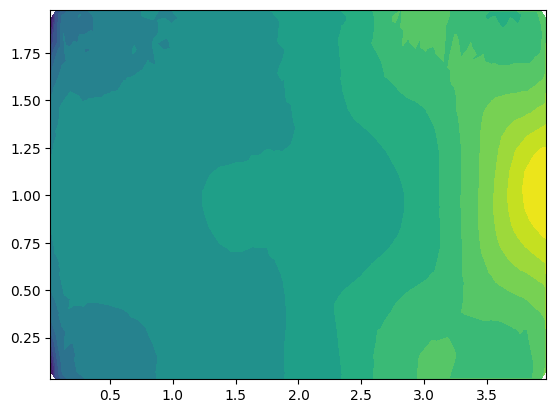

In [ ]:

#| code-fold: true
#| code-summary: "Contour map height field"
# | output: true
cell_centers = np.array(mesh.cell_centers().points)
field_0 = np.array(mesh.cell_data[scalar_field_names[0]])
plt.tricontourf(cell_centers[:,0], cell_centers[:,1], field_0, levels=20)

## Numerical simulation of the pumped storage hydropower system

## Conclusion